## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
##  Using chessboard images to extract object points and image points for camera calibration.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calculate distortion coefficients, and test undistortion on an image.

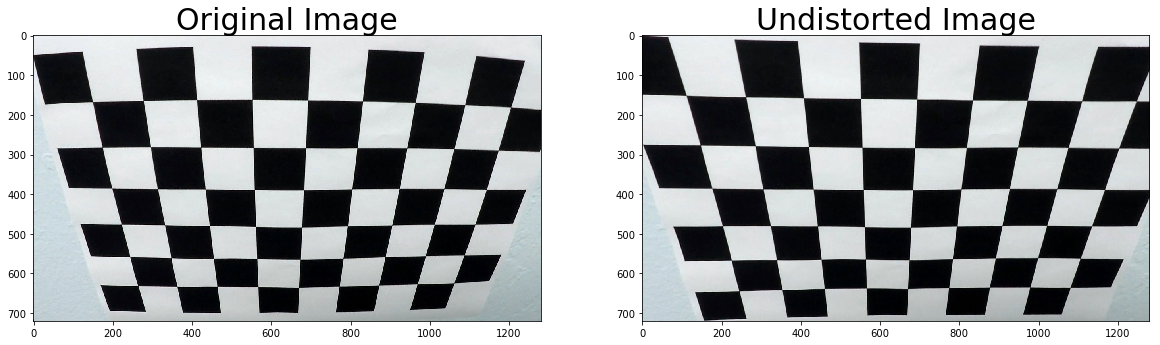

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
# dist: distortion coefficients
# mtx: The camera matrix that we need to transform 3D object points to 2D object points.
# rvecs. tvecs: It also return the positions of the camera in the world, with values of rotaion vectos and translation vectors.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration2_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "dist_coefficient.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Undistort a raw image

Text(0.5,1,'Undistorted Image')

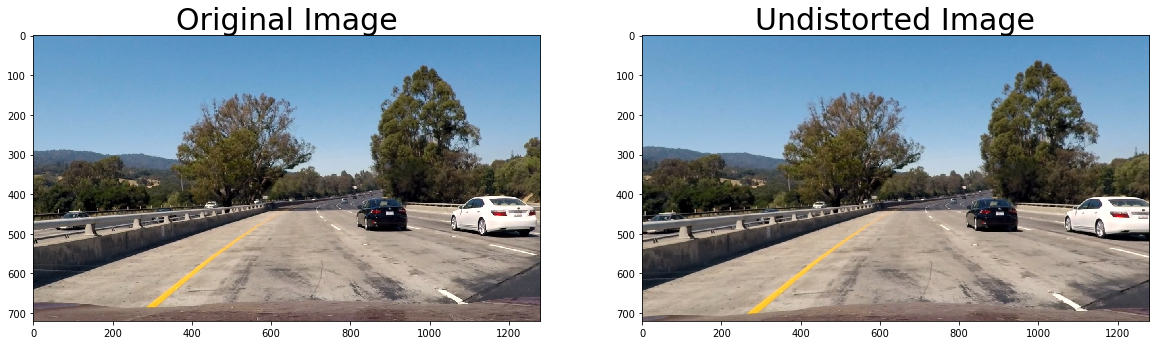

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline

with open('dist_coefficient.p', mode='rb') as f:
    dist_coefficient = pickle.load(f)

mtx = dist_coefficient["mtx"] 
dist = dist_coefficient["dist"]

img = plt.imread("test_images/test1.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/straight_lines2_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

 # Thresholded binary images

In [22]:
def abs_sobel_thresh(rgb_img, orient='x', sobel_kernel=3,thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(rgb_img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(rgb_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def s_channel_thres(rgb_img, sobel_kernel=3, thresh=(0, 255)):
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

def l_channel_thres(rgb_img, sobel_kernel=3, thresh=(0, 255)):
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    return l_binary

def combined_thres(rgb_img):
    ksize = 9
    sxbinary = abs_sobel_thresh(rgb_img, 'x', ksize, (20, 100))
    sbinary = s_channel_thres(rgb_img, ksize, (170, 255))
    l_binary = l_channel_thres(rgb_img, ksize, thresh=(100, 255))
    combined = np.zeros_like(sxbinary)
    
    combined[((sbinary==1)&(l_binary==1))|(sxbinary==1)] = 1
    return combined

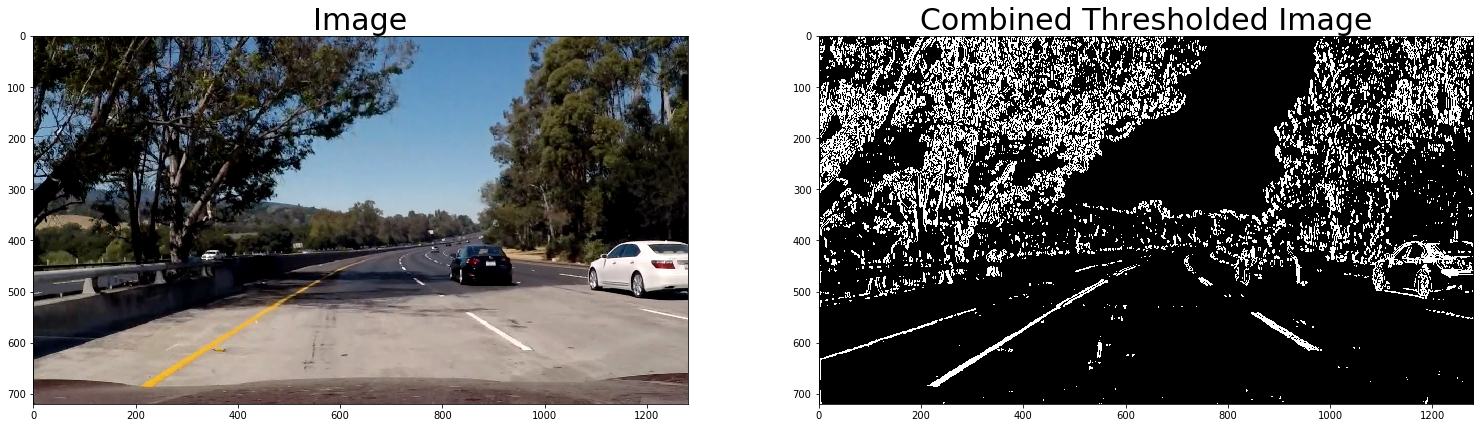

In [23]:
image = mpimg.imread('test_images/test5.jpg')
img = np.copy(image)

thres_img = combined_thres(img)

#color_binary = np.dstack(( np.zeros_like(combined), sbinary, combined)) * 255
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Image', fontsize=30)
ax2.imshow(thres_img, cmap='gray')
ax2.set_title('Combined Thresholded Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform
- Find approximate perspective transform source points.
- Test perspective transform 

Text(0.5,1,'Undistorted and warped Image')

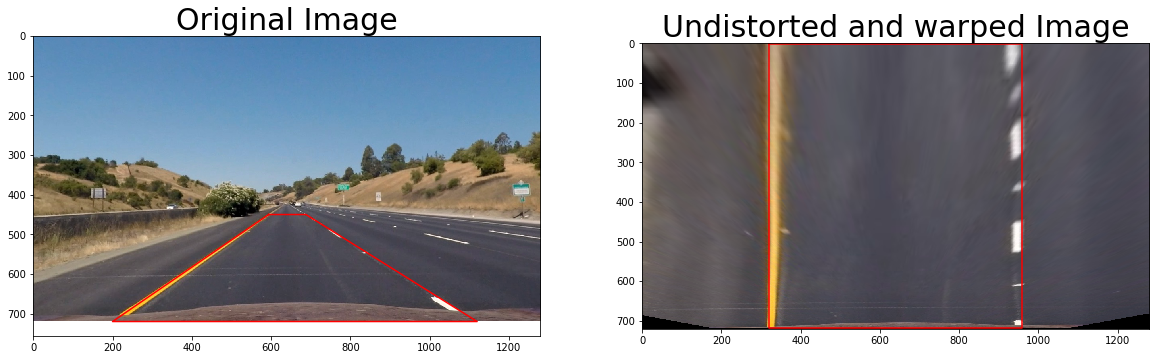

In [24]:
import matplotlib
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import cv2
import pickle

%matplotlib inline

# assume road is flat plane, use a undist striaght line image. 
straight_lines2_undist_img = plt.imread('output_images/straight_lines1_undist.jpg')
straight_lines2_undist_img = cv2.cvtColor(straight_lines2_undist_img, cv2.COLOR_BGR2RGB)
img_sz = (straight_lines2_undist_img.shape[1], straight_lines2_undist_img.shape[0])


PT_SRC = np.float32([[594,450], [688,450],[1120, 720], [200, 720]])
PT_DST = np.float32([[320, 2], [img_sz[0] - 320, 2], [img_sz[0] - 320, img_sz[1] - 2], [320, img_sz[1] - 2]])

M = cv2.getPerspectiveTransform(PT_SRC, PT_DST)
Minv = cv2.getPerspectiveTransform(PT_DST, PT_SRC)

PerspectiveTransform_pickle = {}
PerspectiveTransform_pickle["M"] = M
PerspectiveTransform_pickle["Minv"] = Minv
pickle.dump( PerspectiveTransform_pickle, open( "PerspectiveTransform.p", "wb" ) )

warped = cv2.warpPerspective(straight_lines2_undist_img, M, img_sz, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(straight_lines2_undist_img)
ax1.plot(np.append(PT_SRC[:,0],594), np.append(PT_SRC[:,1], 450),color='red')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.plot(np.append(PT_DST[:,0], 320),np.append(PT_DST[:,1], 2), color='red')
ax2.set_title('Undistorted and warped Image', fontsize=30)


## Detect Lanes

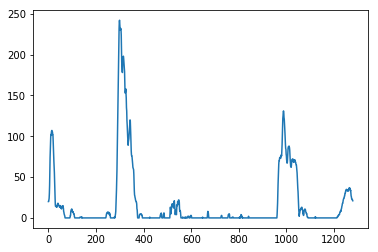

In [38]:
import numpy as np
with open('dist_coefficient.p', mode='rb') as f:
    dist_coefficient = pickle.load(f)

mtx = dist_coefficient["mtx"] 
dist = dist_coefficient["dist"]

image = plt.imread("test_images/test5.jpg")
undist = cv2.undistort(image, mtx, dist, None, mtx)

thres_img = combined_thres(undist) 
thres_warped_img = cv2.warpPerspective(thres_img, M, img_sz, flags=cv2.INTER_LINEAR)
histogram = np.sum(thres_warped_img[thres_warped_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

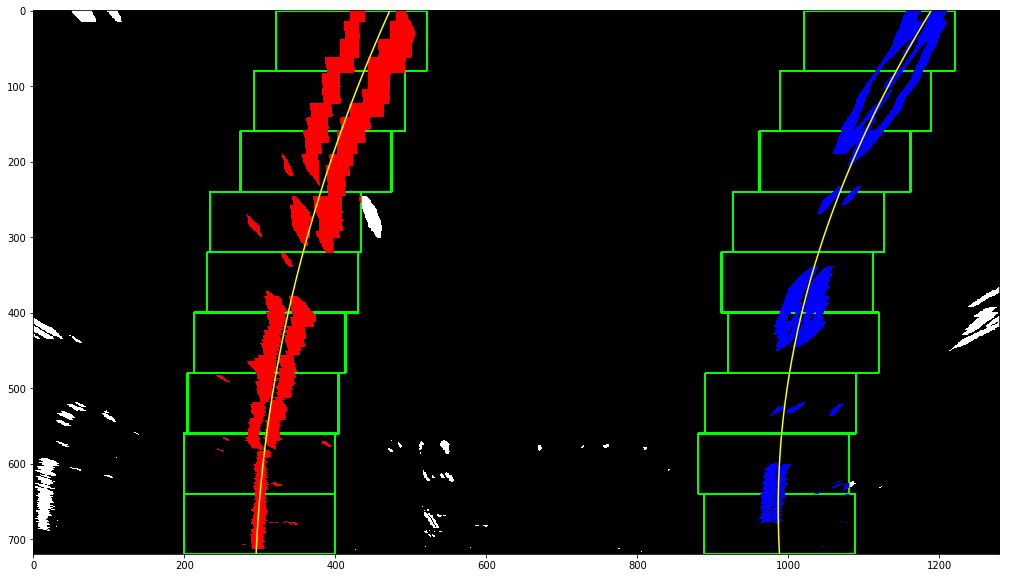

In [39]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Take a histogram of the bottom half of the image
histogram = np.sum(thres_warped_img[thres_warped_img.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((thres_warped_img, thres_warped_img, thres_warped_img))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(thres_warped_img.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = thres_warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = thres_warped_img.shape[0] - (window+1)*window_height
    win_y_high = thres_warped_img.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, thres_warped_img.shape[0]-1, thres_warped_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
f = plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

## Lane Width

14.605988024925555
1778.7847733317492 1077.5426345699232


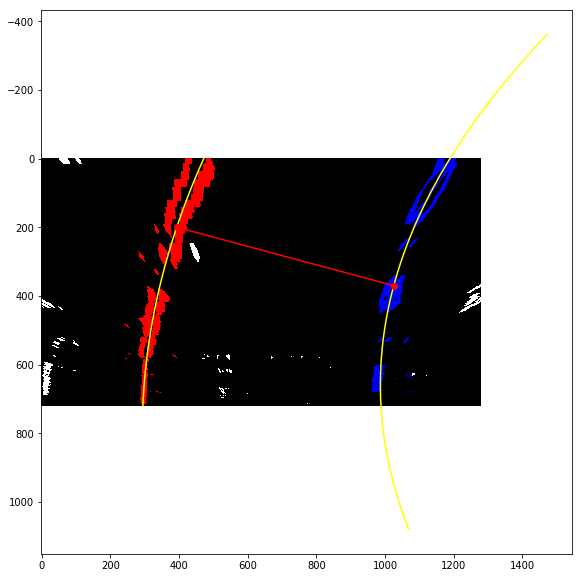

In [40]:
import shapely.geometry as geom
import numpy as np

out_img = np.dstack((thres_warped_img, thres_warped_img, thres_warped_img))*255

# Generate x and y values for plotting
ploty = np.linspace(0, thres_warped_img.shape[0]-1, thres_warped_img.shape[0] )
extend_ploty = np.linspace(-0.5 * thres_warped_img.shape[0], thres_warped_img.shape[0] * 1.5 -1, 2*thres_warped_img.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
extend_right_fitx = right_fit[0]*extend_ploty**2 + right_fit[1]*extend_ploty + right_fit[2]
extend_right_fit_pts = np.vstack((extend_right_fitx, extend_ploty)).T


line = geom.LineString(np.array(extend_right_fit_pts))
point = geom.Point(left_fitx[200], ploty[200])


left_fit_pts = np.vstack((left_fitx, ploty)).T
#print(left_fit_pts)
line2line_distance = [line.distance(geom.Point(p)) for p in left_fit_pts]
print(np.std(line2line_distance, ddof=1))

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
f = plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(extend_right_fitx, extend_ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

point_on_line = line.interpolate(line.project(point))
plt.plot([point.x, point_on_line.x], [point.y, point_on_line.y], 
color='red', marker='o', scalex=False, scaley=False)

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

### Look ahead filter

(720, 0)

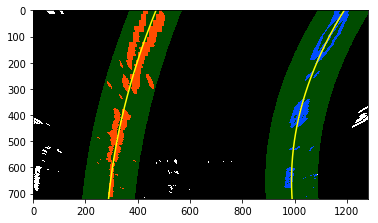

In [41]:

nonzero = thres_warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, thres_warped_img.shape[0]-1, thres_warped_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((thres_warped_img, thres_warped_img, thres_warped_img))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Determine the curvature of the lane and vehicle position with respect to center.

In [43]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

y_eval = np.max(ploty)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
print('radius of curvature: ', (left_curverad+right_curverad)/2, 'm')

position =  (thres_warped_img.shape[1]/2 - (left_fitx[-1] + right_fitx[-1])/2) * xm_per_pix
print('vehicle position with respect to center: ', position, 'm')


774.1012894155277 m 345.74942474470004 m
radius of curvature:  559.9253570801138 m
vehicle position with respect to center:  0.0029355635670503945 m


## Project the lane back down onto the image

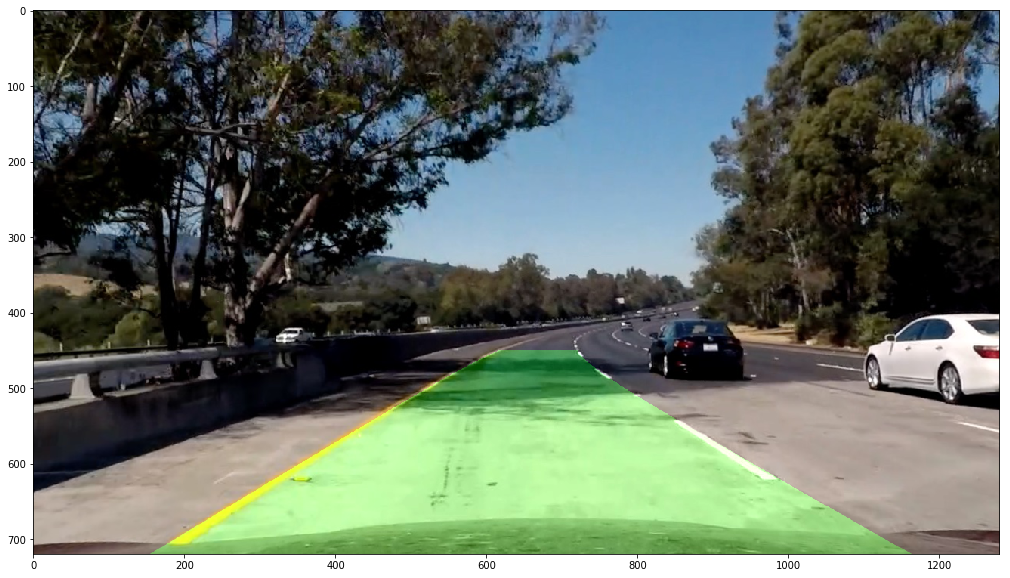

In [44]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(thres_warped_img).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
f = plt.figure(figsize=(20,10))
plt.imshow(result)

# Define Lane Finding pipeline

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import shapely.geometry as geom

%matplotlib inline

with open('dist_coefficient.p', mode='rb') as f:
    dist_coefficient = pickle.load(f)
mtx = dist_coefficient["mtx"] 
dist = dist_coefficient["dist"]

with open('PerspectiveTransform.p', mode='rb') as f:
    PerspectiveTransform_pickle = pickle.load(f)
M = PerspectiveTransform_pickle["M"] 
Minv = PerspectiveTransform_pickle["Minv"]

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


def abs_sobel_thresh(rgb_img, orient='x', sobel_kernel=3,thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(rgb_img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(rgb_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def s_channel_thres(rgb_img, sobel_kernel=3, thresh=(0, 255)):
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

def l_channel_thres(rgb_img, sobel_kernel=3, thresh=(0, 255)):
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    return l_binary

def combined_thres(rgb_img):
    ksize = 9
    sxbinary = abs_sobel_thresh(rgb_img, 'x', ksize, (20, 100))
    sbinary = s_channel_thres(rgb_img, ksize, (170, 255))
    l_binary = l_channel_thres(rgb_img, ksize, thresh=(100, 255))
    combined = np.zeros_like(sxbinary)
    
    combined[((sbinary==1)&(l_binary==1))|(sxbinary==1)] = 1
    return combined

def detect_lane_from_scratch(thres_warped_img, gen_output_img=False):
    histogram = np.sum(thres_warped_img[thres_warped_img.shape[0]//2:,:], axis=0)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(thres_warped_img[thres_warped_img.shape[0]//2:,:], axis=0)
    if gen_output_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((thres_warped_img, thres_warped_img, thres_warped_img))*255
    else:
        out_img = None
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(thres_warped_img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = thres_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = thres_warped_img.shape[0] - (window+1)*window_height
        win_y_high = thres_warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if gen_output_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)  
    
    return out_img, leftx, lefty, rightx, righty, left_fit, right_fit

def look_ahead_lane_detection(thres_warped_img, pre_left_fit, pre_right_fit, gen_output_img=False, margin=100):
    nonzero = thres_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (pre_left_fit[0]*(nonzeroy**2) + pre_left_fit[1]*nonzeroy + 
    pre_left_fit[2] - margin)) & (nonzerox < (pre_left_fit[0]*(nonzeroy**2) + 
    pre_left_fit[1]*nonzeroy + pre_left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (pre_right_fit[0]*(nonzeroy**2) + pre_right_fit[1]*nonzeroy + 
    pre_right_fit[2] - margin)) & (nonzerox < (pre_right_fit[0]*(nonzeroy**2) + 
    pre_right_fit[1]*nonzeroy + pre_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, thres_warped_img.shape[0]-1, thres_warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if gen_output_img:
        out_img = np.dstack((thres_warped_img, thres_warped_img, thres_warped_img))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    else:
        result = None
    return result, leftx, lefty, rightx, righty, left_fit, right_fit

def cal_curvature(thres_warped_img, leftx, lefty, rightx, righty, ploty):
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

def cal_lane_width(thres_warped_img, left_fitx, right_fit):
    ploty = np.linspace(0, thres_warped_img.shape[0]-1, thres_warped_img.shape[0])
    extend_ploty = np.linspace(-0.5 * thres_warped_img.shape[0], thres_warped_img.shape[0] * 1.5 -1, 2*thres_warped_img.shape[0])
    extend_right_fitx = right_fit[0]*extend_ploty**2 + right_fit[1]*extend_ploty + right_fit[2]
    extend_right_fit_pts = np.vstack((extend_right_fitx, extend_ploty)).T
    right_line = geom.LineString(np.array(extend_right_fit_pts))
    left_fit_pts = np.vstack((left_fitx, ploty)).T
    line2line_distance = [right_line.distance(geom.Point(p)) for p in left_fit_pts]
    return line2line_distance

def cal_position(thres_warped_img, left_fitx, right_fitx):
    position =  (thres_warped_img.shape[1]/2 - (left_fitx[-1] + right_fitx[-1])/2) * xm_per_pix
    return position

def project_lane(undist, thres_warped_img, left_fitx, right_fitx, ploty, color=(0,255, 0)):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(thres_warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), color)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (thres_warped_img.shape[1], thres_warped_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, current_fit, radius_of_curvature, recent_fitx, allx, ally):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = recent_fitx
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = current_fit
        #radius of curvature of the line in meters
        self.radius_of_curvature  = radius_of_curvature 
        self.best_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        self.best_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = allx  
        #y values for detected line pixels
        self.ally = ally


LEFT_LINEs = []
RIGHT_LINEs = []
KEEP_TRACK_OF_FRAMES = 50
BEST_FIT_SAMPLES = 30
LANE_WIDTH_THRES_IN_PIXEL_AVG_MIN = 520
LANE_WIDTH_THRES_IN_PIXEL_MIN = 460
LANE_WIDTH_THRES_IN_PIXEL_MAX = 720
REASIONABLE_CURVATURE_THRES_MIN = 100
LANE_WIDTH_STD_THRES_MIN = 75
RESET_AFTER_LANE_LOST_CNT = 25
verboes=False
l_best_x = [] 
r_best_x = []
best_radius_of_curvature = None
best_base_pos = None

def LANE_FINDING_PIPELINE(rgb_img):
    global LEFT_LINEs
    global RIGHT_LINEs
    global l_best_x
    global r_best_x
    global best_radius_of_curvature
    global best_base_pos
    
    img = np.copy(rgb_img)
    image_size = (img.shape[1],img.shape[0])
    # undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Thresholding image
    thres_img = combined_thres(undist) 
    
    # Perspective Transform
    thres_warped_img = cv2.warpPerspective(thres_img, M, image_size, flags=cv2.INTER_LINEAR)
    
    # detect lane on current image
    look_ahead_filter_applied = False
    idx = 0
    if len(LEFT_LINEs):
        for idx, left_line in enumerate(LEFT_LINEs[::-1]):
            if idx > RESET_AFTER_LANE_LOST_CNT:
                # reset
                out_img, leftx, lefty, rightx, righty, left_fit, right_fit = detect_lane_from_scratch(thres_warped_img)
                LEFT_LINEs = []
                RIGHT_LINEs = []
                break
            #print(idx)
            if left_line.detected:
                pre_left_fit = LEFT_LINEs[::-1][idx].best_fit
                pre_right_fit = RIGHT_LINEs[::-1][idx].best_fit
                out_img, leftx, lefty, rightx, righty, left_fit, right_fit = look_ahead_lane_detection(thres_warped_img, \
                                                                                                       pre_left_fit, pre_right_fit)
                look_ahead_filter_applied = True
                #print("look ahead")
                break
            if len(LEFT_LINEs) == (idx + 1):
                out_img, leftx, lefty, rightx, righty, left_fit, right_fit = detect_lane_from_scratch(thres_warped_img)
    else:
        out_img, leftx, lefty, rightx, righty, left_fit, right_fit = detect_lane_from_scratch(thres_warped_img)
        
    # 
    ploty = np.linspace(0, thres_warped_img.shape[0]-1, thres_warped_img.shape[0])
    #print(len(left_fit))
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # calculate curvature and position
    left_curvatrue, right_curvature = cal_curvature(thres_warped_img, leftx, lefty, rightx, righty, ploty)
    position = cal_position(thres_warped_img, left_fitx, right_fitx)
    '''
    print('left. radius of curvature: ', left_curverad, 'm')
    print('right. radius of curvature: ', right_curverad, 'm')
    print('vehicle position with respect to center: ', position, 'm')
    '''
    
    dtct_l_l = Line(left_fit, left_curvatrue, left_fitx, leftx, lefty)
    dtct_r_l = Line(right_fit, right_curvature, right_fitx, rightx, righty)
    dtct_l_l.line_base_pos = position
    dtct_r_l.line_base_pos = position
    
    # detected line sanity check
    lane_width = cal_lane_width(thres_warped_img, left_fitx, right_fit)
    lane_width_resonable = (LANE_WIDTH_THRES_IN_PIXEL_MIN < lane_width[0]) and \
    (LANE_WIDTH_THRES_IN_PIXEL_AVG_MIN < np.mean(lane_width)) and (max(lane_width) < LANE_WIDTH_THRES_IN_PIXEL_MAX)
    lane_curvatrue_reasonable = (left_curvatrue > REASIONABLE_CURVATURE_THRES_MIN) and (right_curvature > REASIONABLE_CURVATURE_THRES_MIN)
    # roughly parallel: at any part of the lane, the lane witdh shall roughly identical 
    Lane_roughly_parallel = np.std(lane_width, ddof=1) < LANE_WIDTH_STD_THRES_MIN
    
    if lane_width_resonable and lane_curvatrue_reasonable and Lane_roughly_parallel:
        # we get a confifent detection
        dtct_l_l.detected = True
        dtct_r_l.detected = True
        #print("left current_fit: {}".format(dtct_l_l.current_fit))
    
    # keep track of lane lines
    LEFT_LINEs.append(dtct_l_l)
    RIGHT_LINEs.append(dtct_r_l)
    if len(LEFT_LINEs) > KEEP_TRACK_OF_FRAMES:
        LEFT_LINEs.pop(0)
        RIGHT_LINEs.pop(0)
    #print("tracking frames: {}".format(len(LEFT_LINEs)))
    
    # find best lane line 
    if dtct_l_l.detected:
        # pick up index of last BEST_FIT_SAMPLES detected lines
        last_valid_lines_idx = np.array([l_line.detected for l_line in LEFT_LINEs]).nonzero()[0][-BEST_FIT_SAMPLES:]
        #print("last_valid_lines_idx: {}".format(last_valid_lines_idx))
        l_valid_fits = np.array([LEFT_LINEs[idx].current_fit for idx in last_valid_lines_idx])
        r_valid_fits = np.array([RIGHT_LINEs[idx].current_fit for idx in last_valid_lines_idx])
        l_valid_curv = np.array([LEFT_LINEs[idx].radius_of_curvature for idx in last_valid_lines_idx])
        r_valid_curv = np.array([RIGHT_LINEs[idx].radius_of_curvature for idx in last_valid_lines_idx])
        l_valid_pos = np.array([LEFT_LINEs[idx].line_base_pos for idx in last_valid_lines_idx])
        # smooth the detected lane's fit/curvature/position over frames
        w = np.arange(1, len(l_valid_fits)+1, dtype=np.float32)
        dtct_l_l.best_fit = np.average(l_valid_fits, weights=w, axis=0)
        dtct_r_l.best_fit = np.average(r_valid_fits, weights=w, axis=0)
        dtct_l_l.best_x = dtct_l_l.best_fit[0]*ploty**2 + dtct_l_l.best_fit[1]*ploty + dtct_l_l.best_fit[2]
        dtct_r_l.best_x = dtct_r_l.best_fit[0]*ploty**2 + dtct_r_l.best_fit[1]*ploty + dtct_r_l.best_fit[2]
        dtct_l_l.best_curvature =  np.average(l_valid_curv, weights=w, axis=0)
        dtct_r_l.best_curvature =  np.average(r_valid_curv, weights=w, axis=0)
        dtct_l_l.best_base_pos =  np.average(l_valid_pos, weights=w, axis=0)
        #print("l_valid_fits: {}".format(l_valid_fits))
    
    # project best lane back down onto undistort image
    valid_lines_idx = np.array([l_line.detected for l_line in LEFT_LINEs]).nonzero()[0]
    if len(valid_lines_idx):
        last_best_idx = valid_lines_idx[-1]
        l_best_x = LEFT_LINEs[last_best_idx].best_x
        r_best_x = RIGHT_LINEs[last_best_idx].best_x
        best_radius_of_curvature = (LEFT_LINEs[last_best_idx].best_curvature + RIGHT_LINEs[last_best_idx].best_curvature) / 2.0
        best_base_pos = LEFT_LINEs[last_best_idx].best_base_pos
        #print("LEFT_LINEs[{}].best_fit: {}".format(last_best_idx, LEFT_LINEs[last_best_idx].best_fit))
    if len(l_best_x):
        lane_image = project_lane(undist, thres_warped_img, l_best_x, r_best_x, ploty)
        font=cv2.FONT_HERSHEY_SIMPLEX
        lane_image=cv2.putText(lane_image,'Radius of Curvature: {}m'.format(best_radius_of_curvature),
                               (10, 15),font,0.6,(0,255,0),2)
        lane_image=cv2.putText(lane_image,'Vehicle is off center: {}m'.format(best_base_pos),
                               (10, 35),font,0.6,(0,255,0),2)
    else:
        lane_image = undist
    
        
    '''
    if dtct_l_l.detected:
        if look_ahead_filter_applied:
            lane_image = project_lane(undist, thres_warped_img, left_fitx, right_fitx, ploty, color=(0,0,255))
        else:
            lane_image = project_lane(undist, thres_warped_img, left_fitx, right_fitx, ploty)
    else:
        lane_image = project_lane(undist, thres_warped_img, left_fitx, right_fitx, ploty, color=(255,0,0))
    '''
    if verboes:
        if idx > RESET_AFTER_LANE_LOST_CNT:
            cv2.rectangle(lane_image,(0,0),(lane_image.shape[1],lane_image.shape[0]), (255,0,0), 20)
        font=cv2.FONT_HERSHEY_SIMPLEX
        clr = (255,0,0)
        if lane_width_resonable:
            clr = (0,255,0)
        lane_image=cv2.putText(lane_image,\
                               'lane_width_resonable: {} avg:{:.2f} [0]:{:.2f} [-1]:{:.2f} min:{:.2f} max:{:.2f}'.format(lane_width_resonable, np.mean(lane_width), lane_width[0], lane_width[-1], min(lane_width), max(lane_width)),(10,670),font,0.6,clr,2)
        clr = (255,0,0)
        if lane_curvatrue_reasonable:
            clr = (0,255,0)
        lane_image=cv2.putText(lane_image,'lane_curvatrue_reasonable: {} {}'.format(lane_curvatrue_reasonable, left_curvatrue),
                               (10,690),font,0.6,clr,2)
        clr = (255,0,0)
        if Lane_rouggly_parallel:
            clr = (0,255,0)
        lane_image=cv2.putText(lane_image,'Lane_rouggly_parallel: {} {}'.format(Lane_rouggly_parallel, np.std(lane_width, ddof=1)),
                               (10,710),font,0.6,clr,2)
        
    '''
    if look_ahead_filter_applied:
        if idx > 0:
            lane_image = project_lane(undist, thres_warped_img, left_fitx, right_fitx, ploty, color=(0,0,255))
        else:
            lane_image = project_lane(undist, thres_warped_img, left_fitx, right_fitx, ploty)
    else:
        lane_image = project_lane(undist, thres_warped_img, left_fitx, right_fitx, ploty, color=(255,0,0))
    '''
    
    return lane_image

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = LANE_FINDING_PIPELINE(image)
    return result

In [3]:
prj_output2 = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip2 = VideoFileClip("project_video.mp4").subclip(20,26)
#clip2 = VideoFileClip("project_video.mp4").subclip(0,10)
clip2 = VideoFileClip("project_video.mp4")#.subclip(0,2)
clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(prj_output2, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:13<00:00,  2.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 10min 18s
